# Import modules

In [5]:
import os
import time
import torch
import torch.optim as optim
import torchvision.utils as vutils
from src.metrics import calculate_metrics
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from pathlib import Path
from tqdm import tqdm

from src.data_utils import load_and_preprocess_data
from src.models import Generator, Discriminator
from src.utils import weights_init, compute_gradient_penalty, add_dp_noise_to_gradients

# Preview data

In [6]:
class Config:
    # --- Cấu hình thiết bị và dữ liệu ---
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    IMG_SIZE = 128
    IMG_CHANNELS = 1
    DATA_PATH = ""
    # Đường dẫn dữ liệu trên Kaggle
    DATA_PATH_CSV = "./dataset/nii_paths.csv" 
    LATENT_SIZE = 128

    # --- Cấu hình Training ---
    EPOCHS = 250 # Giảm để chạy nhanh hơn trên Kaggle
    BATCH_SIZE = 32
    LR = 0.0001
    BETA1 = 0.5
    BETA2 = 0.9
    CRITIC_ITERATIONS = 4
    LAMBDA_GP = 10

    # --- Cấu hình Differential Privacy (DP) - Tắt theo mặc định ---
    ADD_DP_NOISE = False
    NOISE_MULTIPLIER = 1.1
    MAX_GRAD_NORM = 1.0
    
    # --- Cấu hình Lưu trữ & Logging ---
    OUTPUT_DIR = Path("./")
    SAMPLE_INTERVAL = 500
    MODEL_SAVE_INTERVAL = 25 # Lưu ít thường xuyên hơn
    FIXED_NOISE_SIZE = 64 
    LR_SCHEDULER_STEP_SIZE = 50  # Giảm LR sau mỗi 50 epochs
    LR_SCHEDULER_GAMMA = 0.5     # Giảm LR đi một nửa

    # --- Cấu hình đánh giá FID ---
    METRIC_CALC_INTERVAL = 5 

config = Config()

In [ ]:
os.makedirs(config.FID_REAL_IMAGES_DIR, exist_ok=True)
os.makedirs(config.FID_FAKE_IMAGES_DIR, exist_ok=True)

dataloader = load_and_preprocess_data(config)

Bắt đầu tải và tiền xử lý dữ liệu MRI...
Đã tải 10000 lát cắt.
Tiền xử lý hoàn tất trong 9.21 giây.
Đang tạo DataLoader...
DataLoader sẵn sàng với 313 batch.


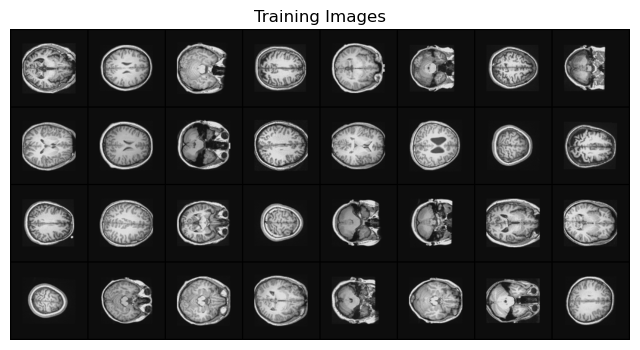

In [8]:
# Hiển thị một batch ảnh để kiểm tra
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(vutils.make_grid(real_batch[0].to(config.DEVICE)[:64], padding=2, normalize=True).cpu().permute(1, 2, 0))
plt.show()

# Create model and optimizer

In [9]:
generator = Generator(config.LATENT_SIZE, config.IMG_CHANNELS, config.IMG_SIZE).to(config.DEVICE)
discriminator = Discriminator(config.IMG_CHANNELS, config.IMG_SIZE).to(config.DEVICE)

generator.apply(weights_init)
discriminator.apply(weights_init)

optimizer_g = optim.Adam(generator.parameters(), lr=config.LR, betas=(config.BETA1, config.BETA2))
optimizer_d = optim.Adam(discriminator.parameters(), lr=config.LR, betas=(config.BETA1, config.BETA2))

fixed_noise = torch.randn(config.FIXED_NOISE_SIZE, config.LATENT_SIZE, device=config.DEVICE)

# Train model

In [10]:
# Bắt đầu vòng lặp training
print("Bắt đầu quá trình training...")
start_time = time.time()

# Toàn bộ logic training từ file train.py cũ được đưa vào đây
# ... (Copy-paste logic training vào đây) ...
g_losses, d_losses, real_scores, fake_scores = [], [], [], []
total_batches = len(dataloader)
global_step = 0

# List để lưu lại lịch sử train
ssim_history = []
fid_history = []
metric_epochs = []

for epoch in range(1, config.EPOCHS + 1):
    epoch_start_time = time.time()
    epoch_g_loss = 0.0
    epoch_d_loss = 0.0
    
    # Bật progress bar cho mỗi epoch
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{config.EPOCHS}")

    for batch_idx, (real_imgs,) in enumerate(pbar):
        real_imgs = real_imgs.to(config.DEVICE)
        batch_size = real_imgs.size(0)

        # --- Huấn luyện Discriminator ---
        discriminator.train()
        generator.train()
        
        d_loss_iter = 0
        for _ in range(config.CRITIC_ITERATIONS):
            optimizer_d.zero_grad()
            z = torch.randn(batch_size, config.LATENT_SIZE, device=config.DEVICE)
            
            with torch.no_grad():
                fake_imgs = generator(z)
            
            real_validity = discriminator(real_imgs)
            fake_validity = discriminator(fake_imgs)
            
            gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, fake_imgs.data, config.DEVICE, config.LAMBDA_GP)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + gradient_penalty
            
            d_loss.backward()
            if config.ADD_DP_NOISE:
                add_dp_noise_to_gradients(discriminator, config.NOISE_MULTIPLIER, config.MAX_GRAD_NORM)
            optimizer_d.step()
            d_loss_iter += d_loss.item()
        
        epoch_d_loss += (d_loss_iter / config.CRITIC_ITERATIONS)

        # --- Huấn luyện Generator ---
        optimizer_g.zero_grad()
        # Tạo ảnh giả mới để huấn luyện generator
        z_gen = torch.randn(batch_size, config.LATENT_SIZE, 1, 1, device=config.DEVICE)
        gen_imgs = generator(z_gen)
        validity = discriminator(gen_imgs)
        g_loss = -torch.mean(validity)
        
        g_loss.backward()
        optimizer_g.step()
        epoch_g_loss += g_loss.item()

        # Cập nhật progress bar
        pbar.set_postfix({
            "D Loss": f"{(epoch_d_loss / (batch_idx + 1)):.4f}",
            "G Loss": f"{(epoch_g_loss / (batch_idx + 1)):.4f}"
        })

    # Lưu loss trung bình của epoch
    avg_d_loss = epoch_d_loss / len(dataloader)
    avg_g_loss = epoch_g_loss / len(dataloader)
    d_losses.append(avg_d_loss)
    g_losses.append(avg_g_loss)

    # --- Lưu ảnh và tính toán Metrics sau mỗi epoch ---
    generator.eval()
    with torch.no_grad():
        fake_samples = generator(fixed_noise).detach().cpu()
    vutils.save_image(fake_samples, config.OUTPUT_DIR / f"images/epoch_{epoch:03d}.png", normalize=True)
    
    # Tính toán và in metrics định kỳ
    if epoch % METRIC_CALC_INTERVAL == 0 or epoch == config.EPOCHS:
        print(f"--- Calculating metrics for epoch {epoch} ---")
        metrics = calculate_metrics(generator, dataloader, config.DEVICE, config.LATENT_SIZE, num_batches=50)
        ssim_history.append(metrics['ssim'])
        fid_history.append(metrics['fid'])
        metric_epochs.append(epoch)
        print(f"==> Epoch {epoch} Metrics: SSIM = {metrics['ssim']:.4f} | FID = {metrics['fid']:.2f}")

    # Lưu model checkpoint
    if epoch % config.MODEL_SAVE_INTERVAL == 0:
        torch.save(generator.state_dict(), config.OUTPUT_DIR / f"models/generator_epoch_{epoch:03d}.pt")

print(f"\nTraining hoàn tất trong {(time.time() - start_time)/60:.2f} phút.")

# Lưu model cuối cùng
torch.save(generator.state_dict(), config.OUTPUT_DIR / "models/generator_final.pt")

print(f"Training hoàn tất trong {(time.time() - start_time)/60:.2f} phút.")

# Lưu model cuối cùng
torch.save(generator.state_dict(), config.OUTPUT_DIR / "models/generator_final.pt")


Bắt đầu quá trình training...


Epoch 1/250:   0%|          | 0/313 [00:00<?, ?it/s]libc++abi: terminating with uncaught exception of type std::__1::system_error: Broken pipe
libc++abi: terminating with uncaught exception of type std::__1::system_error: Broken pipe
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x12d475d80>
Traceback (most recent call last):
  File "/opt/miniconda3/envs/ml_base/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    def __del__(self):
  File "/opt/miniconda3/envs/ml_base/lib/python3.10/site-packages/torch/utils/data/_utils/signal_handling.py", line 66, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 54983) is killed by signal: Abort trap: 6. 
Epoch 1/250:   0%|          | 0/313 [00:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# --- Vẽ đồ thị kết quả ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Đồ thị Loss
ax1.plot(g_losses, label="Generator Loss")
ax1.plot(d_losses, label="Discriminator Loss")
ax1.set_title("Training Losses")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.grid(True)

# Đồ thị SSIM và FID
ax2_ssim = ax2
ax2_fid = ax2.twinx() # Tạo trục y thứ hai cho FID

# Vẽ SSIM
line1 = ax2_ssim.plot(metric_epochs, ssim_history, 'g-', label='SSIM (càng cao càng tốt)')
ax2_ssim.set_xlabel('Epochs')
ax2_ssim.set_ylabel('SSIM', color='g')
ax2_ssim.tick_params(axis='y', labelcolor='g')

# Vẽ FID
line2 = ax2_fid.plot(metric_epochs, fid_history, 'b-', label='FID (càng thấp càng tốt)')
ax2_fid.set_ylabel('FID', color='b')
ax2_fid.tick_params(axis='y', labelcolor='b')

# Gộp legend từ cả hai trục
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax2.legend(lines, labels, loc='best')

ax2.set_title('Model Evaluation Metrics')
fig.tight_layout()
plt.show()